<a href="https://colab.research.google.com/github/mnwato/nlp-projects/blob/master/text-Classification-using-bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

from transformers import BertTokenizer, BertTokenizerFast

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from keras.layers import Dense

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
useTPU = False

In [3]:
!gdown --id 1eBv1-DDZGxdFxOAAOoGzAEjtp_WSRb1I

Downloading...
From: https://drive.google.com/uc?id=1eBv1-DDZGxdFxOAAOoGzAEjtp_WSRb1I
To: /content/train.csv
100% 20.1M/20.1M [00:00<00:00, 123MB/s]


In [4]:
df = pd.read_csv('train.csv')
df.head(2)

,Input,Output,Label
0,I'd like to start by talking about prices .,I'd be glad to answer any questions you may h...,1
1,Why ? Isn't it obvious ? First you impose way...,"I'm very sorry for that , but I sent you seve...",1


In [6]:
sentences = df['Input']

In [9]:
# The PlotLosses function, plots the validation and training loss function during the
#  training to give an insight of training the model
# from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLosses(tf.keras.callbacks.Callback):
  
    def on_train_begin(self, logs={}):
        self.i = 1
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(8,3))
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.grid()
        plt.show();
        
        plt.figure(figsize=(8,3))
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.grid()
        plt.show();
        
        print('*******************************')
        print('Validation metrics:')
        print('val_losses: {}'.format(round(self.val_losses[-1], 3)),
        'val_accuracy: {}'.format(round(self.val_accuracy[-1], 3)) )
        
plot_losses = PlotLosses()

{44: 2088, 135: 202, 92: 652, 21: 1674, 83: 838, 24: 1990, 26: 2192, 18: 1236, 157: 154, 41: 2242, 63: 1266, 65: 1234, 95: 536, 36: 2330, 67: 1140, 34: 2502, 37: 2354, 23: 2028, 48: 1944, 30: 2258, 89: 668, 61: 1438, 132: 284, 70: 1042, 84: 860, 58: 1578, 27: 2080, 118: 290, 71: 1022, 88: 676, 25: 2134, 120: 332, 43: 2102, 100: 456, 62: 1340, 126: 254, 156: 100, 80: 896, 79: 922, 31: 2372, 22: 1854, 20: 1672, 60: 1508, 28: 2172, 56: 1550, 12: 602, 155: 168, 33: 2446, 19: 1350, 50: 1928, 16: 1290, 39: 2234, 110: 398, 66: 1132, 59: 1448, 32: 2412, 42: 2290, 38: 2332, 165: 110, 115: 320, 76: 976, 72: 1034, 17: 1404, 81: 830, 29: 2194, 151: 190, 98: 498, 55: 1532, 160: 128, 97: 516, 211: 48, 111: 408, 362: 4, 40: 2490, 104: 454, 57: 1626, 53: 1666, 78: 872, 93: 564, 105: 408, 101: 510, 69: 1082, 194: 88, 148: 186, 114: 302, 113: 300, 47: 1970, 64: 1290, 94: 530, 136: 228, 54: 1608, 45: 2100, 8: 578, 86: 764, 35: 2470, 75: 1056, 15: 986, 107: 414, 183: 82, 177: 84, 85: 778, 51: 1828, 129: 2

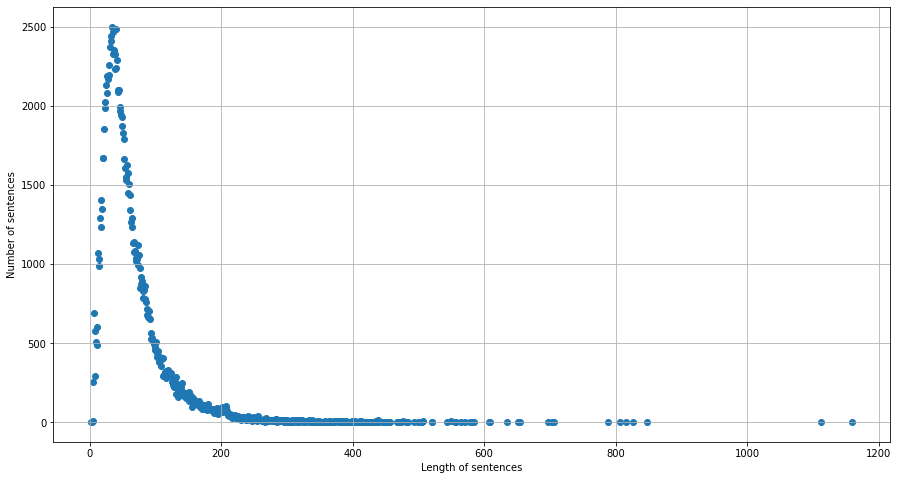

mean:62.98912586125283, std:49.73214399575116


In [10]:
# نمودار فراوانی طول جملات 

def plot_seq_len_distribution(corpus):
  sentences = corpus
  sent_length = {}

  for elem in sentences:
    res = len(elem)
    if res in sent_length:
      sent_length[res]+=1
    else:
      sent_length[res]=1

  print(sent_length)


  import matplotlib.pyplot as plt

  x = [key for key in sent_length] # length
  y = [sent_length[key] for key in sent_length] # number of sentences

  plt.figure(figsize=(15,8))
  plt.scatter(x, y)
  plt.xlabel('Length of sentences')
  plt.ylabel('Number of sentences')
  plt.grid()
  plt.show()


  mean = np.mean([len(sent) for sent in sentences]) 
  std = np.std([len(sent) for sent in sentences]) 
  print('mean:{}, std:{}'.format(mean, std))

plot_seq_len_distribution(sentences)

In [11]:
max_len = 70

# معرفی توکنایزر برت
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')



# اعمال توکنایزر برت
def encode_texts(tokenizer, texts):
    # return tokenizer(texts, padding=True, truncation=True, return_tensors="tf")
    return tokenizer(texts, add_special_tokens=True, max_length=max_len, pad_to_max_length=True,
                     return_attention_mask=True, return_tensors="tf")

In [12]:
texts = [d for d in sentences]
tds = encode_texts(bert_tokenizer, texts)
tds.keys()

encoded_texts = tds

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [14]:
# آماده سازی استفاده از TPU در صورت فعال بودن
if useTPU == True:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU: ', tpu.cluster_spec().as_dict()['worker'])

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Replicas: ', strategy.num_replicas_in_sync)

In [15]:
from transformers import TFBertModel, TFBertForPreTraining, BertForTokenClassification

tf.get_logger().setLevel('ERROR')

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.NONE
)


def create_model():
  bert = TFBertModel.from_pretrained('bert-base-uncased')

  # define inputs layers
  input_ids = tf.keras.layers.Input(shape=(max_len,), name='input_ids', dtype='int32')
  input_mask = tf.keras.layers.Input(shape=(max_len,), name='attention_mask', dtype='int32')

  # define bert embedding layers
  embeddings = bert(input_ids=input_ids, attention_mask=input_mask)[1]

  # define output layers
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(embeddings)

  # define Model
  bert_model0 = tf.keras.Model(inputs=[input_ids, input_mask], outputs=output)

  bert_model0.summary()

  return bert_model0


def prepair_model():
  model = create_model()

  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-8)
  model.compile(optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                            

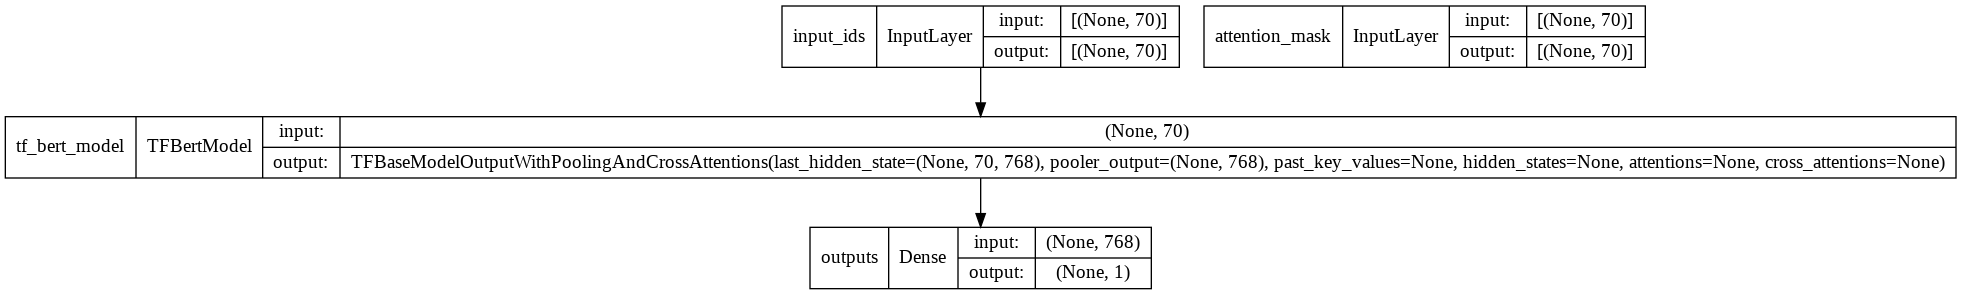

In [16]:
model = create_model()

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
def data_spliting(data, train_size, valid_size):
    
    train_len = int(len(data) * train_size)
    valid_len = int((len(data) - train_len) * valid_size)
    test_len = (len(data) - train_len) - valid_len
    print(f'Total data len {len(data)}\n',
          f' training data len {train_len}\n',
          f'  validation data len {valid_len}\n'
          f'    test data len {test_len}')
    return train_len, valid_len, test_len


train_len, valid_len, test_len = data_spliting(data=df,
                                               train_size=0.8,
                                               valid_size=0)
xtrain = {"input_ids": encoded_texts["input_ids"][0:train_len+valid_len],
         "attention_mask": encoded_texts["attention_mask"][0:train_len+valid_len]}
ytrain = df['Label'][0:train_len+valid_len].astype('int')

xtest = {"input_ids": encoded_texts["input_ids"][train_len+valid_len:],
         "attention_mask": encoded_texts["attention_mask"][train_len+valid_len:]}
ytest = df['Label'][train_len+valid_len:].astype('int')

print()
len(ytrain), len(ytest)

Total data len 152104
  training data len 121683
   validation data len 0
    test data len 30421



(121683, 30421)

In [ ]:
def fit_model(model):
  
  history = model.fit(xtrain, ytrain,
                      batch_size=32,
                      epochs=5,
                      validation_split=0.2,
                      callbacks=[plot_losses]
                      )

if useTPU == True: # train with TPU
  with strategy.scope():
    model = prepair_model()
    fit_model(model)
else: # train with CPU/GPU
  model = prepair_model()
  fit_model(model)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                          